# 2.0 Train model and save the results

Setup

In [1]:
import torch

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Using device: {device}")

Using device: mps


## Prepare data

Define dataset parameters and transforms

In [3]:
from torchvision import transforms

# train_mean = [0.3186241388320923, 0.2931755483150482, 0.3017965853214264]
# train_std = [0.2762017846107483, 0.2654302418231964, 0.2686000168323517]

train_mean = [0.5, 0.5, 0.5]
train_std = [0.5, 0.5, 0.5]


class ContrastStretch(object):
    def __call__(self, img):
        # img: Tensor [C,H,W] in [0,1]
        lo, hi = img.min(), img.max()
        return (img - lo) / (hi - lo + 1e-5)

transform = transforms.Compose([
    transforms.ToTensor(),
    ContrastStretch(),
    transforms.Normalize(mean=train_mean, std=train_std),
])

Load the dataset

In [4]:
from torchvision.datasets import ImageFolder

train_dir = "./data/train"
train_ds = ImageFolder(train_dir, transform=transform)

num_classes = len(train_ds.classes)

print(f"Number of train images: {len(train_ds)}")
print(f"Number of train classes: {num_classes}")

Number of train images: 31367
Number of train classes: 43


Prepare data loaders

In [5]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

## Create model

Define the latent space

In [6]:
latent_dim = 100

Define the model

In [7]:
from gnn import Generator, Discriminator

generator = Generator(num_classes, latent_dim=latent_dim).to(device)
discriminator = Discriminator(num_classes).to(device)

## Train model

Define training parameters

In [8]:
import torch.optim as optim
import torch.nn as nn

G_lr = 4e-4
D_lr = 1e-4

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=G_lr)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=D_lr)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
adv_criterion = nn.BCEWithLogitsLoss()

Train the model

Epoch 0: 100%|██████████| 246/246 [01:24<00:00,  2.93it/s]


Epoch 1: D(real)=0.380  D(fake)=0.909  D_loss=101.115  G_loss=8.315


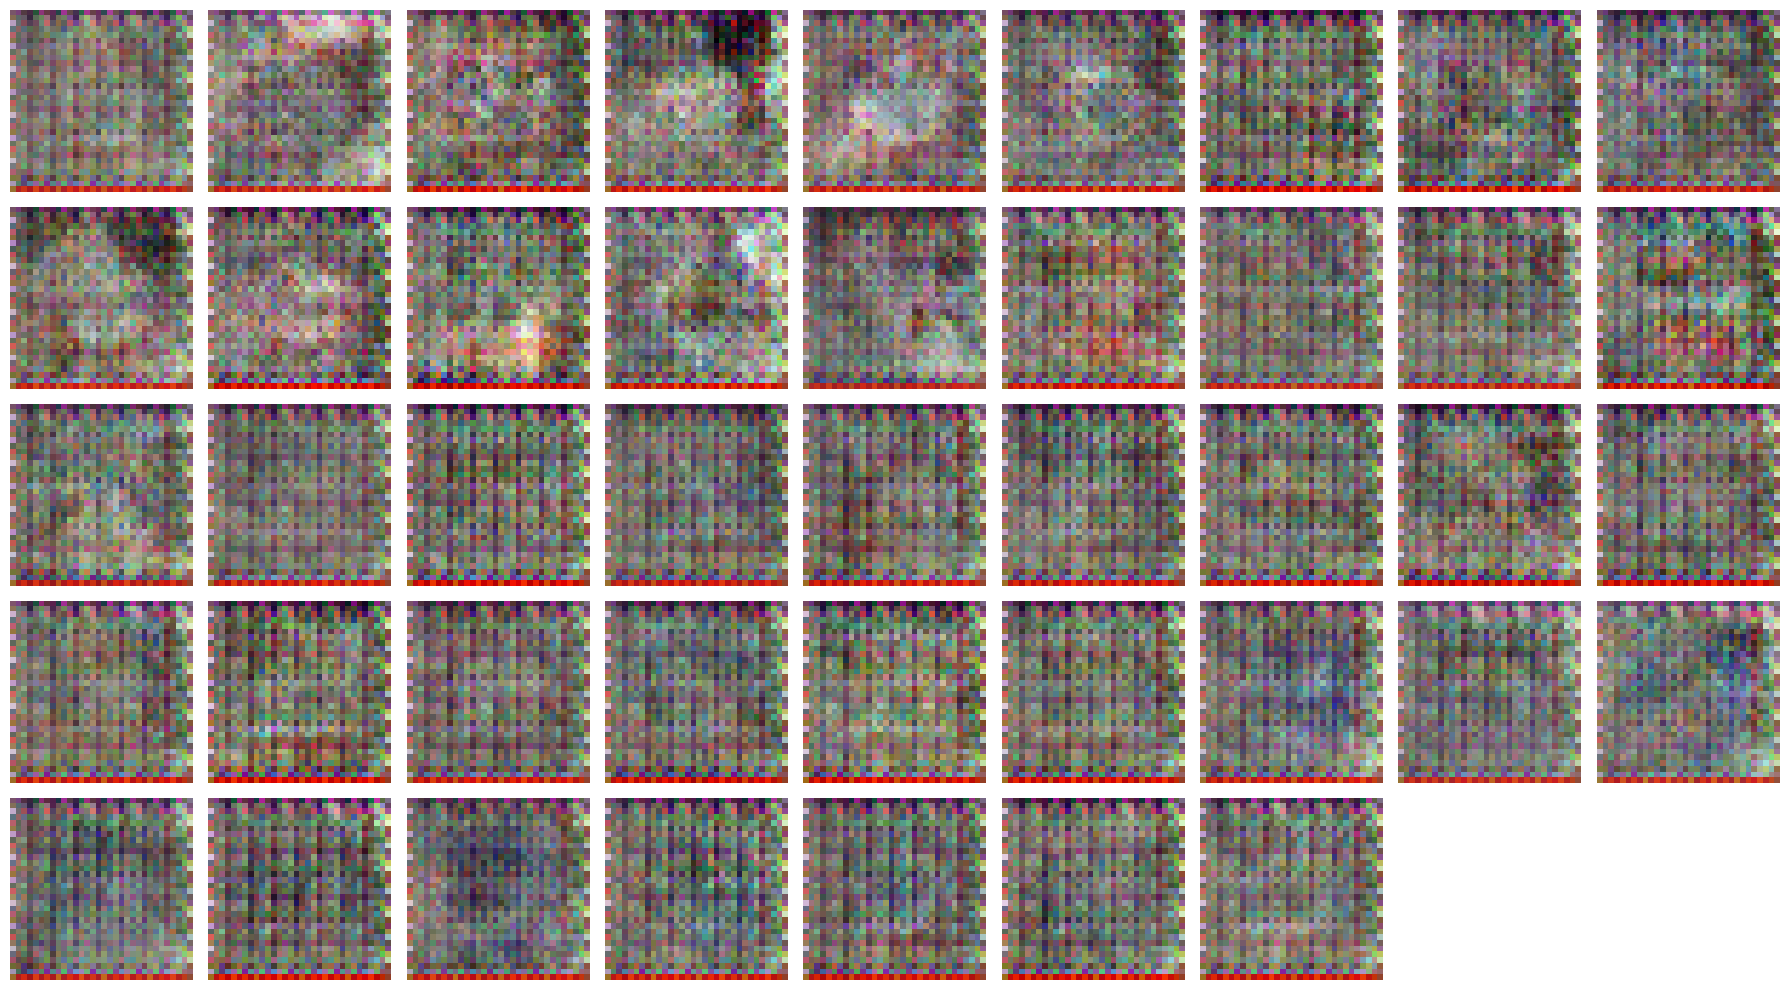

Epoch 1: 100%|██████████| 246/246 [01:26<00:00,  2.83it/s]


Epoch 2: D(real)=0.202  D(fake)=0.815  D_loss=48.667  G_loss=3.442


Epoch 2: 100%|██████████| 246/246 [01:22<00:00,  3.00it/s]


Epoch 3: D(real)=0.309  D(fake)=0.698  D_loss=25.233  G_loss=2.959


Epoch 3: 100%|██████████| 246/246 [01:23<00:00,  2.96it/s]


Epoch 4: D(real)=0.409  D(fake)=0.665  D_loss=17.642  G_loss=2.608


Epoch 4: 100%|██████████| 246/246 [01:20<00:00,  3.07it/s]


Epoch 5: D(real)=0.440  D(fake)=0.592  D_loss=15.100  G_loss=3.029


Epoch 5: 100%|██████████| 246/246 [01:20<00:00,  3.06it/s]


Epoch 6: D(real)=0.473  D(fake)=0.544  D_loss=12.446  G_loss=3.288


Epoch 6:  50%|████▉     | 122/246 [00:40<00:42,  2.93it/s]

In [ ]:
from gnn import Trainer as GNNTrainer

gnn_trainer = GNNTrainer(num_classes, adversarial_criterion=adv_criterion, latent_dim=latent_dim, device=device)
gnn_trainer.set_generator(generator, generator_optimizer, generator_scheduler)
gnn_trainer.set_discriminator(discriminator, discriminator_optimizer, discriminator_scheduler)

# Training
loss = gnn_trainer.fit(train_dl, num_epochs=100, mean=train_mean, std=train_std)

save the model

In [17]:
# Save generator and discriminator weights
import os

weights_dir = "./gnn/weights"

os.makedirs(weights_dir, exist_ok=True)

gen_path = os.path.join(weights_dir, "generator.pth")
disc_path = os.path.join(weights_dir, "discriminator.pth")

torch.save(generator.state_dict(), gen_path)
torch.save(discriminator.state_dict(), disc_path)

print(f"Generator weights saved to: {gen_path}")
print(f"Discriminator weights saved to: {disc_path}")

Generator weights saved to: ./gnn/weights/generator.pth
Discriminator weights saved to: ./gnn/weights/discriminator.pth


## Evaluation

Load test dataset

In [13]:
test_dir = "./data/test"
test_ds = ImageFolder(test_dir)

Generate samples and save them to results folder

In [14]:
import os
import time

from collections import Counter
from torchvision.utils import save_image


results_id = time.time()
results_dir = f"./results/{results_id}"

os.makedirs(results_dir, exist_ok=True)

class_counts = Counter(test_ds.targets)

mean_t = torch.tensor(train_mean).view(1, 3, 1, 1).to(device)
std_t = torch.tensor(train_std).view(1, 3, 1, 1).to(device)

generator.eval()

for cls, cnt in class_counts.items():
    for i in range(cnt):
        z = torch.randn(1, latent_dim, device=device)
        labels = torch.tensor([cls], device=device)
        with torch.no_grad():
            img = generator(z, labels)

        img = img * std_t + mean_t

        fname = os.path.join(results_dir, f"{cls}_{i}.jpg")
        save_image(img.clamp(0, 1), fname)

Calculate the FID between test set and generated images

In [15]:
from pytorch_fid.fid_score import calculate_fid_given_paths

test_flat_dir = "./data/test_flat"
generated_dir = results_dir

fid = calculate_fid_given_paths([test_flat_dir, generated_dir], batch_size, device, dims=2048, num_workers=1)

print(f"FID: {fid}")

100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


FID: 159.54803219509927
